## 测评经过RVC数据的DVAEDecoder模型

In [1]:
import torch
from modules.dvae import DVAEDecoder,GradualDVAEDecoder 

# 假设你的模型权重保存在'best_model.pth'这个文件中
checkpoint_path = "./model-55-0.0000.ckpt"
# checkpoint_path = "./checkpoints/model-89-0.0000.ckpt"
# checkpoint_path = "/private/tmp/March7-decoder/model-55-0.0000.ckpt"

# 加载模型架构
IDIM = 384
ODIM = 100
# model = DVAEDecoder(idim=IDIM, odim=ODIM, bn_dim=64, hidden=128, n_layer=16)  # 根据你的模型初始化参数
# model = DVAEDecoder(idim=IDIM, odim=ODIM, bn_dim=64, hidden=512, n_layer=8)
model = GradualDVAEDecoder(idim=IDIM, odim=ODIM, bn_dim=128, hidden=512, n_layer=4)

# 加载训练好的模型权重
checkpoint = torch.load(checkpoint_path, map_location="cpu", mmap=True)
state_dict = checkpoint['state_dict']

# 处理state_dict的key，去除前缀'model.'，如果存在的话
new_state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()}

# 加载修正后的state_dict
model.load_state_dict(new_state_dict)

# 切换模型到评估模式
model.eval()

# 如果有GPU，将模型移到GPU上
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)

GradualDVAEDecoder(
  (conv_in): Sequential(
    (0): Conv1d(384, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(128, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (decoder_block): ModuleList(
    (0-3): 4 x ConvNeXtBlock(
      (dwconv): Conv1d(512, 512, kernel_size=(7,), stride=(1,), padding=(6,), dilation=(2,), groups=512)
      (norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (pwconv1): Linear(in_features=512, out_features=2048, bias=True)
      (act): GELU(approximate='none')
      (pwconv2): Linear(in_features=2048, out_features=512, bias=True)
    )
  )
  (conv_mid): ModuleList(
    (0): Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): GELU(approximate='none')
    (2): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (3): GELU(approximate='none')
    (4): Conv1d(128, 100, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  )
)

In [2]:
import numpy as np
import os
import random
import torch

def preprocess_features(features_tensor):
    """
    Preprocess the features tensor to prepare it for decoding.
    """
    features_tensor = features_tensor.transpose(1, 2)
    temp = torch.chunk(features_tensor, 2, dim=1)
    temp = torch.stack(temp, -1)
    vq_feats = temp.reshape(*temp.shape[:2], -1)
    return vq_feats

def infer_from_features(model, features_tensor, device):
    """
    Pass preprocessed features through the model and return the output.
    """
    vq_feats = preprocess_features(features_tensor)
    vq_feats = vq_feats.to(device)
    with torch.no_grad():
        output = model(vq_feats)
    return output.to('cpu')

def load_and_forward_npz(model, npz_path, device):
    """
    Load a .npz file's data and pass it through the model's forward method.
    """
    data = np.load(npz_path)
    features = data['hidden']
    features_tensor = torch.from_numpy(features).float()[None]
    
    output = infer_from_features(model, features_tensor, device)
    return output

# 获取训练目录下的所有 .npz 文件路径
npz_files_dir = 'train_rvc/'
npz_files = [os.path.join(npz_files_dir, f) for f in os.listdir(npz_files_dir) if f.endswith('.npz')]

In [3]:
#模型下载
from modelscope import snapshot_download
from ChatTTS import Chat
model_dir = snapshot_download('mirror013/ChatTTS')

# 加载模型
chat = Chat()
chat.load_models(
    source="local",
    local_path=model_dir,
    device='cpu',
    compile=False,
)

SEED = 1397
torch.manual_seed(SEED) # 音色种子
# load from local file if exists
if os.path.exists('spk_emb.npy'):
    spk_emb = torch.load('spk_emb.npy',map_location='cpu')
    print("use local speaker embedding")
else:
    spk_emb = chat.sample_random_speaker()
    print("use random speaker embedding")

params_infer_code = {
    'spk_emb': spk_emb,
    'temperature': 0.1,
    'top_P': 0.7,
    'top_K': 20,
}

# params_refine_text = {}
params_refine_text = {'prompt': '[oral_9][laugh_2][break_7]'}


# 对文本进行预处理
new_texts = []


def filter_punctuation(text):
    allowed_punctuations = {".", ",", "!", "?", "，", "。", "！", "？"," "}
    new_text = ""
    for char in text:
        if char.isalnum() or char in allowed_punctuations:
            new_text += char
    return new_text

2024-06-27 22:49:24,402 - modelscope - INFO - PyTorch version 2.1.0 Found.
2024-06-27 22:49:24,403 - modelscope - INFO - Loading ast index from /Users/charslee/.cache/modelscope/ast_indexer
2024-06-27 22:49:24,547 - modelscope - INFO - Loading done! Current index file version is 1.13.3, with md5 8e4efa69aee288a831cd8dd27b421a93 and a total number of 972 components indexed
INFO:ChatTTS.core:Load from local: /Users/charslee/.cache/modelscope/hub/mirror013/ChatTTS
INFO:ChatTTS.core:vocos loaded.
INFO:ChatTTS.core:dvae loaded.
INFO:ChatTTS.core:gpt loaded.
INFO:ChatTTS.core:decoder loaded.
INFO:ChatTTS.core:tokenizer loaded.
INFO:ChatTTS.core:All initialized.


use local speaker embedding


In [13]:
from IPython.display import Audio
import IPython
import IPython.display

# 随机选择一个文件用来合成音频
selected_file = random.choice(npz_files)
print(f"Selected file: {selected_file}")

# 加载选定的 .npz 文件并进行模型前向传播
mel_special_build = load_and_forward_npz(model, selected_file,device=device)
print("Model output shape:", mel_special_build.shape)

with torch.no_grad():
    mel_special_build = mel_special_build.to('cpu')
    audio = chat.pretrain_models['vocos'].decode(mel_special_build)
IPython.display.display(Audio(audio.cpu().numpy(), rate=24000))

# 加载换声后的Mel频谱图
rvc_mel_spec = np.load(f"{selected_file}")['log_mel_spec']
rvc_mel_spec = torch.from_numpy(rvc_mel_spec)
print(f"rvc_mel_spec shape: {rvc_mel_spec.shape}")

# 转回音频信号
with torch.no_grad():
    rvc_mel_spec = rvc_mel_spec.to('cpu')
    audio = chat.pretrain_models['vocos'].decode(rvc_mel_spec[None])
IPython.display.display(Audio(audio.cpu().numpy(), rate=24000))

Selected file: train_rvc/173acf8bbe4bcc56d7592d80e3ed8a5c.npz
Model output shape: torch.Size([1, 100, 232])


rvc_mel_spec shape: torch.Size([100, 229])


In [14]:
def compute_similarity_by_truncating(tensor1, tensor2):
    """
    计算两个Tensor之间的相似率，通过截断使得形状不完全相同的Tensor具有相同的维度。
    
    首先检查两个Tensor除了最后一个维度外的其他维度是否一致，如果不一致则抛出ValueError。
    然后，找到两个张量在最后一个维度上的最小长度，并基于这个长度截断两个张量，使它们在所有维度上匹配。
    接着计算两个张量之间的差异（绝对差值之和），并基于此计算差异率。
    最后返回1减去差异率作为相似率，范围从0到1，值越接近1表示两个Tensor越相似。
    
    参数:
    tensor1 (torch.Tensor): 第一个Tensor。
    tensor2 (torch.Tensor): 第二个Tensor。
    
    返回:
    float: 两个Tensor的相似率，范围在0到1之间。
    
    抛出:
    ValueError: 如果输入的Tensor除了最后一个维度外的其他维度不同。
    """
    # 检查除了最后一个维度外的其他维度是否一致
    if tensor1.shape[:-1] != tensor2.shape[:-1]:
        raise ValueError("Input tensors must have matching dimensions except for the last one.")
    
    # 找到最后一个维度的最小长度
    min_length = min(tensor1.shape[-1], tensor2.shape[-1])
    
    # 截断张量到最小长度
    tensor1_truncated = tensor1[..., :min_length]
    tensor2_truncated = tensor2[..., :min_length]
    
    # 计算绝对差值
    abs_diff = torch.abs(tensor1_truncated - tensor2_truncated)
    
    # 找到所有差异中的最大值，用于归一化
    max_diff = abs_diff.max().item()
    
    # 避免除以零的情况
    if max_diff == 0:
        return 1.0  # 如果没有差异，认为是完全相同，相似率为1
    
    # 归一化差异值
    normalized_diff = abs_diff / max_diff
    
    # 计算平均归一化差异作为相似率的逆指标，然后取其补数得到相似率
    # 注意这里的逻辑不同于直接求和除以元素数，因为我们直接用了归一化后的平均差异
    similarity_rate = 1 - normalized_diff.mean().item()
    
    return similarity_rate

# 对比特定生成和目标音频进行相似度计算
similarity = compute_similarity_by_truncating(rvc_mel_spec,mel_special_build * torch.randn((1,100,379)))
print(f"The similarity rate between the two tensors is: {similarity:.4f}")

RuntimeError: The size of tensor a (232) must match the size of tensor b (379) at non-singleton dimension 2

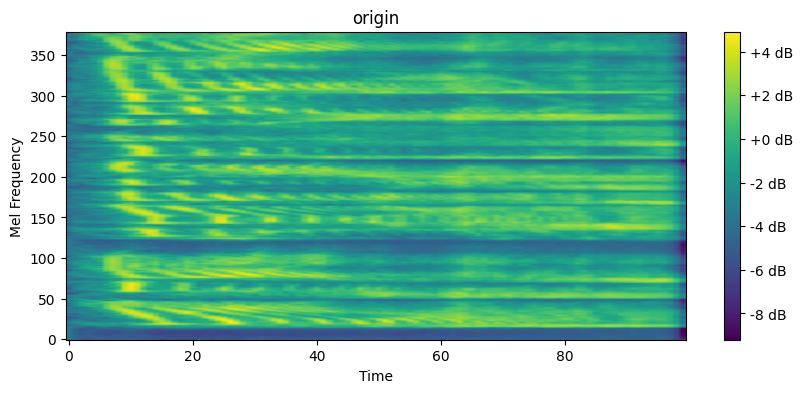

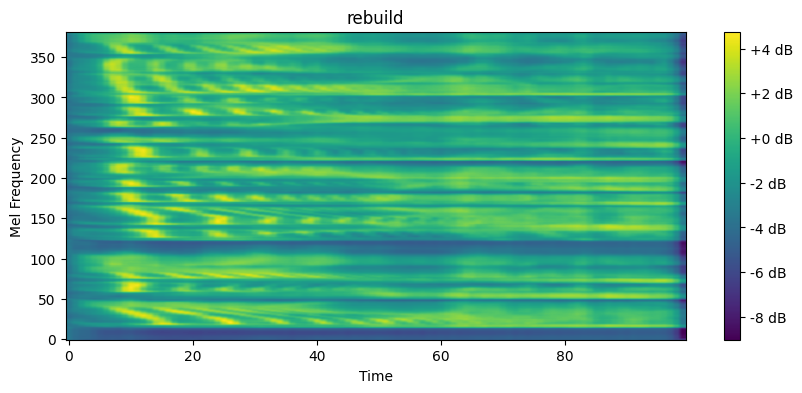

In [6]:
## 打印对比二者的Mel频谱图
import matplotlib.pyplot as plt

def display_mel_table(t: torch.Tensor,title="Log-Mel Spectrogram"):
    # 使用matplotlib绘制Mel频谱图
    plt.figure(figsize=(10, 4))
    plt.imshow(t.T, aspect='auto', origin='lower')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

display_mel_table(rvc_mel_spec, title="origin")
display_mel_table(mel_special_build[0], title="rebuild")

## 尝试从chatTTS中生成特征，使用特制的DVAEDecoder 来进行解码

In [7]:
import IPython

text = "早安！带可莉出去玩吧！我们一起来冒险！"

# 试下纯文本
torch.manual_seed(SEED)
result = chat.infer_debug(text=filter_punctuation(text),params_infer_code=params_infer_code)
hidden = result['hiddens'][0]
print(f"hidden shape: {hidden.shape}")

# 使用特制的DVAEDeocder
mel_special_build = infer_from_features(model, hidden[None], device)

# 再通过vocoas 解码
with torch.no_grad():
    mel_special_build = mel_special_build.to('cpu')
    audio = chat.pretrain_models['vocos'].decode(mel_special_build)
IPython.display.display(Audio(audio.cpu().numpy(), rate=24000))

#原来的音频进行解码
IPython.display.display(Audio(result['wav'][0],rate=24000))

INFO:ChatTTS.core:All initialized.
  6%|▋         | 133/2048 [00:06<01:27, 21.90it/s]


hidden shape: torch.Size([133, 768])


In [8]:
## 尝试有感情的说话

import IPython.display
torch.manual_seed(SEED)
# 先进行参考文本转换
reference_text = chat.infer(text=[filter_punctuation(text)],
                    params_refine_text=params_refine_text,
                    params_infer_code=params_infer_code,
                    do_text_normalization=False,
                    refine_text_only=True)
print(f"参考文本: {reference_text}")


torch.manual_seed(SEED)
hidden = chat.infer(text=reference_text,
                    params_refine_text=params_refine_text,
                    params_infer_code=params_infer_code,
                    do_text_normalization=False,
                    skip_refine_text=True,
                    return_infer_token=True)['hiddens'][0]

# 使用特制的DVAEDeocder
mel_special_build = infer_from_features(model, hidden[None], device)

# 再通过vocoas 解码
with torch.no_grad():
    mel_special_build = mel_special_build.to('cpu')
    audio = chat.pretrain_models['vocos'].decode(mel_special_build)
IPython.display.display(Audio(audio.cpu().numpy(), rate=24000))

torch.manual_seed(SEED)
all_wavs = chat.infer(text=reference_text,
                    skip_refine_text=True,
                    params_infer_code=params_infer_code,
                    do_text_normalization=False)

# 确保所有数组的维度都是 (1, N)，然后进行合并
combined_wavs = np.concatenate(all_wavs, axis=1)
IPython.display.display(Audio(combined_wavs, rate=24000))

print(combined_wavs.shape,audio.cpu().numpy().shape)

INFO:ChatTTS.core:All initialized.
  8%|▊         | 29/384 [00:01<00:19, 18.65it/s]
INFO:ChatTTS.core:All initialized.


参考文本: ['早 安 [laugh] 。 然 后 [uv_break] 就 是 带 可 莉 出 去 玩 吧 。 那 我 们 一 起 来 [uv_break] 呃 冒 险 [laugh] 。']


 15%|█▍        | 304/2048 [00:12<01:13, 23.81it/s]


INFO:ChatTTS.core:All initialized.
 15%|█▍        | 304/2048 [00:11<01:07, 25.70it/s]


mel shape is torch.Size([1, 100, 608])


(1, 155392) (1, 155392)
